# Regression trees



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
import seaborn as sns

from io import StringIO
import sys

import sklearn
import sklearn.linear_model as sl
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

## Data Pre-processing

### Data Loading

In [2]:
df = pd.read_csv("nevada_weather.csv")
# Dropping Year Column
df.drop("Year",axis=1, inplace=True)
# Mapping isDay (false/true) -> (0/1)
df.replace(to_replace=True, value=1, inplace=True)
df.replace(to_replace=False, value=0, inplace=True)
# Dropping columns
df = df.drop(["DHI", "Clearsky DHI", "Clearsky DNI", "Clearsky GHI", "DNI", "Fill Flag", "Dew Point"], axis = 1)

## Model Splitting

In [3]:
# Mapping the data
total_records = len(df)
features = df[:total_records-288].drop('GHI', axis=1).reset_index()
output = df['GHI'][288:].reset_index()
df = pd.concat([features, output], join='inner', axis=1)
df.drop(['index'], axis=1)

,Month,Day,Hour,Minute,Temperature,Cloud Type,Ozone,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,is_day,GHI
0,1,1,0,0,0.6,0,0.342,72.88,167.61,0.14,954,0.4,47,0.5,0,0
1,1,1,0,10,0.5,0,0.342,73.41,167.56,0.14,954,0.4,53,0.5,0,0
2,1,1,0,20,0.4,0,0.343,73.94,167.14,0.14,954,0.4,60,0.5,0,0
3,1,1,0,30,0.4,0,0.343,73.94,166.38,0.14,954,0.4,67,0.5,0,0
4,1,1,0,40,0.3,0,0.344,73.73,165.33,0.14,954,0.4,74,0.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52267,12,29,23,10,6.2,6,0.378,100.00,163.28,0.22,952,1.6,180,0.9,0,0
52268,12,29,23,20,6.2,6,0.378,100.00,164.68,0.22,952,1.6,175,0.9,0,0
52269,12,29,23,30,6.3,6,0.379,100.00,165.89,0.22,952,1.6,170,0.9,0,0
52270,12,29,23,40,6.3,6,0.379,100.00,166.84,0.22,952,1.6,164,0.9,0,0


In [4]:
df_day = df[df.is_day == 1].drop('is_day', axis=1)
df_night = df[df.is_day == 0].drop('is_day', axis=1)

In [5]:
def feature_output_split(x):
    total_records = len(x)
    features = x.drop('GHI', axis=1)
    output = x['GHI']
    return features, output

In [6]:
feature_df, GHI = feature_output_split(df)
day_feature_df, day_GHI = feature_output_split(df_day)
night_feature_df, night_GHI = feature_output_split(df_night)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(feature_df, GHI, test_size=.20, random_state=42)
day_x_train, day_x_test, day_y_train, day_y_test = train_test_split(day_feature_df, day_GHI, test_size=.20, random_state=42)
night_x_train, night_x_test, night_y_train, night_y_test = train_test_split(night_feature_df, night_GHI, test_size=.20, random_state=42)

In [8]:
day_x_train.shape

(21339, 16)

In [9]:
night_x_train.shape

(20478, 16)

In [10]:
day_x_test.shape

(5335, 16)

In [11]:
night_x_test.shape

(5120, 16)

In [12]:
day_y_train.shape

(21339,)

In [13]:
night_y_train.shape

(20478,)

In [14]:
day_y_test.shape

(5335,)

In [15]:
night_y_test.shape

(5120,)

In [16]:
# regression trees

from sklearn.tree import DecisionTreeRegressor
day_regressor = DecisionTreeRegressor(random_state=0, max_depth = 10)
day_regressor.fit(day_x_train, day_y_train)
night_regressor = DecisionTreeRegressor(random_state=0, max_depth = 10)
night_regressor.fit(night_x_train, night_y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [17]:
day_y_train_pred = day_regressor.predict(day_x_train)
day_y_test_pred = day_regressor.predict(day_x_test)

night_y_train_pred = night_regressor.predict(night_x_train)
night_y_test_pred = night_regressor.predict(night_x_test)

In [18]:
print("day train", metrics.mean_squared_error(day_y_train_pred, day_y_train) ** 0.5)
print("day test", metrics.mean_squared_error(day_y_test_pred, day_y_test) ** 0.5)


print("night train", metrics.mean_squared_error(night_y_train_pred, night_y_train) ** 0.5)
print("night test", metrics.mean_squared_error(night_y_test_pred, night_y_test) ** 0.5)

day train 73.62167623564
day test 87.32806398621588
night train 0.8863439109687908
night test 2.8768567690150126


In [19]:
def combine_result(y1, y1_pred, y2, y2_pred):
    combined_y_pred = np.concatenate([y1_pred, y2_pred])
    combined_y = np.concatenate([y1, y2])
    rmse = metrics.mean_squared_error(combined_y, combined_y_pred) ** 0.5
    return rmse

train_rmse = combine_result(day_y_train, day_y_train_pred, night_y_train, night_y_train_pred)
test_rmse = combine_result(day_y_test, day_y_test_pred, night_y_test, night_y_test_pred)

print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE:  52.595246914772375
Test RMSE:  62.41443871450944


## Visualise RMSE scores for different values of depth

In [20]:
def combine_result(y1, y1_pred, y2, y2_pred):
    combined_y_pred = np.concatenate([y1_pred, y2_pred])
    combined_y = np.concatenate([y1, y2])
    rmse = metrics.mean_squared_error(combined_y, combined_y_pred) ** 0.5
    return rmse


max_depths = []
train_rmses = []
test_rmses = []

for max_depth in list(range(2, 30, 2)):
    day_regressor = DecisionTreeRegressor(random_state=0, max_depth = max_depth)
    day_regressor.fit(day_x_train, day_y_train)
    
    night_regressor = DecisionTreeRegressor(random_state=0, max_depth = max_depth)
    night_regressor.fit(night_x_train, night_y_train)
    
    day_y_train_pred = day_regressor.predict(day_x_train)
    day_y_test_pred = day_regressor.predict(day_x_test)
    night_y_train_pred = night_regressor.predict(night_x_train)
    night_y_test_pred = night_regressor.predict(night_x_test)
    
    train_rmse = combine_result(day_y_train, day_y_train_pred, night_y_train, night_y_train_pred)
    test_rmse = combine_result(day_y_test, day_y_test_pred, night_y_test, night_y_test_pred)
    print("Train RMSE: ", train_rmse)
    print("Test RMSE: ", test_rmse)
    max_depths.append(max_depth)
    test_rmses.append(test_rmse)
    train_rmses.append(train_rmse)
    
print(max_depths)
print(test_rmses)
print(train_rmses)

Train RMSE:  94.32687824147841
Test RMSE:  95.240426446735
Train RMSE:  78.1136183161037
Test RMSE:  79.11249360869482
Train RMSE:  70.52983113498178
Test RMSE:  73.42492289468524
Train RMSE:  63.37679992587552
Test RMSE:  67.39892239071304
Train RMSE:  52.595246914772375
Test RMSE:  62.41443871450944
Train RMSE:  41.918002765344006
Test RMSE:  62.74483298396859
Train RMSE:  32.23521798634503
Test RMSE:  59.94841452145116
Train RMSE:  22.417241637429896
Test RMSE:  59.60937662734252
Train RMSE:  13.752885746637386
Test RMSE:  58.3295078021935
Train RMSE:  7.818186295037468
Test RMSE:  59.51749274581537
Train RMSE:  4.033071739218156
Test RMSE:  60.02443230335947
Train RMSE:  1.7036449332346089
Test RMSE:  59.36719834605354
Train RMSE:  0.8137142454847863
Test RMSE:  60.28872620533295
Train RMSE:  0.38124663894111777
Test RMSE:  59.995348813024385
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
[95.240426446735, 79.11249360869482, 73.42492289468524, 67.39892239071304, 62.4144387145

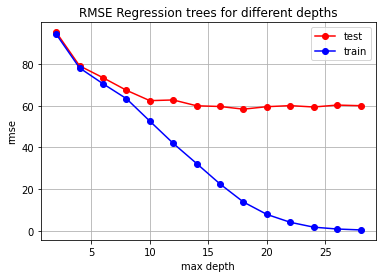

In [21]:
plt.plot(max_depths, test_rmses, 'o-', color='r', label='test')
plt.plot(max_depths, train_rmses, 'o-', color='b', label='train')
plt.title("RMSE Regression trees for different depths")
plt.xlabel('max depth')
plt.ylabel('rmse')
plt.grid()
plt.legend()
plt.savefig('regression tree rmse.jpg')
plt.show()


## Plotting regression trees

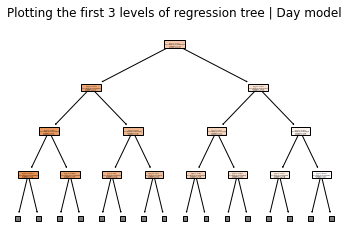

In [22]:
sklearn.tree.plot_tree(day_regressor, filled=True, max_depth=3)
plt.title('Plotting the first 3 levels of regression tree | Day model')
plt.savefig('day_regressor.jpg', dpi=1200)
plt.show()

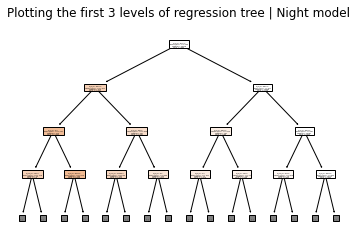

In [23]:
sklearn.tree.plot_tree(night_regressor, filled=True, max_depth=3)
plt.title('Plotting the first 3 levels of regression tree | Night model')
plt.savefig('night_regressor.jpg', dpi=1200)
plt.show()

## Train on complete dataset

In [24]:
final_regressor = DecisionTreeRegressor(random_state=0, max_depth = 10)
final_regressor.fit(x_train, y_train)

y_train_pred = final_regressor.predict(x_train)
y_test_pred = final_regressor.predict(x_test)

train_rmse = metrics.mean_squared_error(y_train, y_train_pred) ** 0.5
test_rmse = metrics.mean_squared_error(y_test, y_test_pred) ** 0.5

print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Train RMSE:  51.54781854337986
Test RMSE:  60.85268630724976


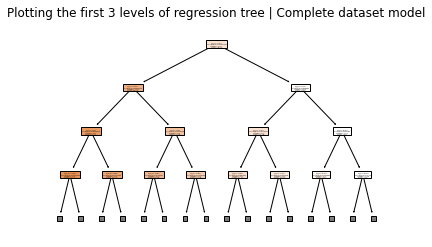

In [25]:
sklearn.tree.plot_tree(final_regressor, filled=True, max_depth=3)
plt.title('Plotting the first 3 levels of regression tree | Complete dataset model')
plt.savefig('complete_regressor.jpg', dpi=1200)
plt.show()

## Save models to pickle files

In [26]:
import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

save_object(day_regressor, 'day_regressor.pkl')
save_object(night_regressor, 'night_regressor.pkl')
save_object(final_regressor, 'complete_regressor.pkl')